In [1]:
import warnings 
warnings.filterwarnings('ignore')

In [2]:
import os
import random
import numpy as np
import pandas as pd 
from skimage import io
from skimage import color
from PIL import Image
import PIL.Image
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
from dask.array.image import imread
from dask import bag, threaded
from dask.diagnostics import ProgressBar
import cv2
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")


from keras import backend as K
from keras.layers.core import Dense, Activation
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import imagenet_utils
from keras.layers import Dense,GlobalAveragePooling2D
from keras.applications import MobileNet
from keras.applications.mobilenet import preprocess_input
from IPython.display import Image


import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten,Input
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import to_categorical
from keras.preprocessing import image 
from keras.layers.normalization import BatchNormalization
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.models import Model
from keras import optimizers


Using TensorFlow backend.


In [3]:
import os
os.getcwd()

'/home/jupyter'

In [4]:
driver_details = pd.read_csv('driver_imgs_list.csv',na_values='na')
print(driver_details.head(5))

  subject classname            img
0    p002        c0  img_44733.jpg
1    p002        c0  img_72999.jpg
2    p002        c0  img_25094.jpg
3    p002        c0  img_69092.jpg
4    p002        c0  img_92629.jpg


In [5]:
## Getting all the images

train_image = []
image_label = []


for i in range(10):
    print('now we are in the folder C',i)
    imgs = os.listdir("/home/jupyter/TrainImages/train/c"+str(i))
    for j in range(len(imgs)):
    #for j in range(100):
        img_name = "/home/jupyter/TrainImages/train/c"+str(i)+"/"+imgs[j]
        img = cv2.imread(img_name)
        #img = color.rgb2gray(img)
        img = img[50:,120:-50]
        img = cv2.resize(img,(224,224))
        label = i
        driver = driver_details[driver_details['img'] == imgs[j]]['subject'].values[0]
        train_image.append([img,label,driver])
        image_label.append(i)





now we are in the folder C 0
now we are in the folder C 1
now we are in the folder C 2
now we are in the folder C 3
now we are in the folder C 4
now we are in the folder C 5
now we are in the folder C 6
now we are in the folder C 7
now we are in the folder C 8
now we are in the folder C 9


In [6]:
## Randomly shuffling the images

import random
random.shuffle(train_image)

In [7]:
# ## getting list of driver names

# D = []
# for features,labels,drivers in train_image:
#     D.append(drivers)

# ## Deduplicating drivers

# deduped = []

# for i in D:
#     if i not in deduped:
#         deduped.append(i)
    

# ## selecting random drivers for the validation set
# driv_selected = []
# import random
# driv_nums = random.sample(range(len(deduped)), 4)
# for i in driv_nums:
#     driv_selected.append(deduped[i])


In [8]:
driv_selected = ['p050', 'p015', 'p022', 'p056']

In [9]:
## Splitting the train and test

X_train= []
y_train = []
X_test = []
y_test = []
D_train = []
D_test = []

for features,labels,drivers in train_image:
    if drivers in driv_selected:
        X_test.append(features)
        y_test.append(labels)
        D_test.append(drivers)
    
    else:
        X_train.append(features)
        y_train.append(labels)
        D_train.append(drivers)
    
print (len(X_train),len(X_test))
print (len(y_train),len(y_test))

18732 3692
18732 3692


In [10]:
## Converting images to nparray. Encoding the Y

X_train = np.array(X_train).reshape(-1,224,224,3)
X_test = np.array(X_test).reshape(-1,224,224,3)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)


print (X_train.shape)

(18732, 224, 224, 3)


# Model

In [11]:
base_model=MobileNet(weights='imagenet',include_top=False) #imports the mobilenet model and discards the last 1000 neuron layer.
# base_model.summary()

In [12]:
x=base_model.output
x=GlobalAveragePooling2D()(x)

# x=Dense(1024,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.

# x = Dropout(0.1)(x) # ****reduce dropout 

# x=Dense(1024,activation='relu')(x) #dense layer 2

# x = BatchNormalization()(x)
# x = Dropout(0.5)(x)

# x=Dense(512,activation='relu')(x) #dense layer 3

preds=Dense(10,activation='softmax')(x) #final layer with softmax activation

model = Model(inputs=base_model.input, outputs=preds)

model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, None, None, 3)     0         
_________________________________________________________________
conv1 (Conv2D)               (None, None, None, 32)    864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, None, None, 32)    128       
_________________________________________________________________
conv1_relu (ReLU)            (None, None, None, 32)    0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, None, None, 32)    288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, None, None, 32)    128 

In [13]:
# for layer in model.layers:
#     layer.trainable=False
# # or if we want to set the first 20 layers of the network to be non-trainable
# for layer in model.layers[:20]:
#     layer.trainable=False
# for layer in model.layers[20:]:
#     layer.trainable=True

In [14]:
from keras import optimizers  

#adam = optimizers.Adam(lr=0.001) #tried 0.0005 - too slow and didn't converge
sgd = optimizers.SGD(lr = 0.005) # try 0.01 - didn't converge and 0.005 , 0.001 best acc of 11%

model.compile(optimizer=sgd,loss='categorical_crossentropy',metrics=['accuracy']) # create object


In [15]:
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint,EarlyStopping

checkpointer = ModelCheckpoint('mobilenet_sgd_nolayers.hdf5', verbose=1, save_best_only=True)
earlystopper = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

datagen = ImageDataGenerator(
    height_shift_range=0.5,
    width_shift_range = 0.5,
    zoom_range = 0.5,
    rotation_range=30
        )
#datagen.fit(X_train)
data_generator = datagen.flow(X_train, y_train, batch_size = 64)

# Fits the model on batches with real-time data augmentation:
mobilenet_model = model.fit_generator(data_generator,steps_per_epoch = len(X_train) / 64, callbacks=[checkpointer, earlystopper],
                                                            epochs = 25, verbose = 1, validation_data = (X_test, y_test))



Epoch 1/25
293/292 [==============================] - 182s 620ms/step - loss: 1.8309 - accuracy: 0.3781 - val_loss: 1.0645 - val_accuracy: 0.6579

Epoch 00001: val_loss improved from inf to 1.06453, saving model to mobilenet_sgd_nolayers.hdf5
Epoch 2/25
293/292 [==============================] - 174s 595ms/step - loss: 1.0360 - accuracy: 0.6666 - val_loss: 0.6174 - val_accuracy: 0.7906

Epoch 00002: val_loss improved from 1.06453 to 0.61739, saving model to mobilenet_sgd_nolayers.hdf5
Epoch 3/25
293/292 [==============================] - 173s 591ms/step - loss: 0.7862 - accuracy: 0.7451 - val_loss: 0.5379 - val_accuracy: 0.8069

Epoch 00003: val_loss improved from 0.61739 to 0.53792, saving model to mobilenet_sgd_nolayers.hdf5
Epoch 4/25
293/292 [==============================] - 171s 585ms/step - loss: 0.6663 - accuracy: 0.7809 - val_loss: 0.4837 - val_accuracy: 0.8245

Epoch 00004: val_loss improved from 0.53792 to 0.48371, saving model to mobilenet_sgd_nolayers.hdf5
Epoch 5/25
293/

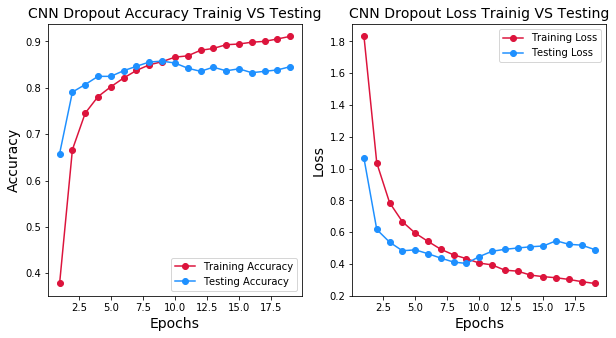

In [17]:
fig, axes = plt.subplots(1, 2, figsize = (10, 5))
axes[0].plot(range(1, len(model.history.history['accuracy']) + 1), model.history.history['accuracy'], linestyle = 'solid', marker = 'o', color = 'crimson', label = 'Training Accuracy')
axes[0].plot(range(1, len(model.history.history['val_accuracy']) + 1), model.history.history['val_accuracy'], linestyle = 'solid', marker = 'o', color = 'dodgerblue', label = 'Testing Accuracy')
axes[0].set_xlabel('Epochs', fontsize = 14)
axes[0].set_ylabel('Accuracy',fontsize = 14)
axes[0].set_title('CNN Dropout Accuracy Trainig VS Testing', fontsize = 14)
axes[0].legend(loc = 'best')
axes[1].plot(range(1, len(model.history.history['loss']) + 1), model.history.history['loss'], linestyle = 'solid', marker = 'o', color = 'crimson', label = 'Training Loss')
axes[1].plot(range(1, len(model.history.history['val_loss']) + 1), model.history.history['val_loss'], linestyle = 'solid', marker = 'o', color = 'dodgerblue', label = 'Testing Loss')
axes[1].set_xlabel('Epochs', fontsize = 14)
axes[1].set_ylabel('Loss',fontsize = 14)
axes[1].set_title('CNN Dropout Loss Trainig VS Testing', fontsize = 14)
axes[1].legend(loc = 'best')

# TEST

Image number: 0
Image number: 1
Image number: 2
Image number: 3
Image number: 4
Image number: 5
Image number: 6
Image number: 7
Image number: 8
Image number: 9
Image number: 10
Image number: 11
Image number: 12
Image number: 13
Image number: 14
Image number: 15
Image number: 16
Image number: 17
Image number: 18
Image number: 19


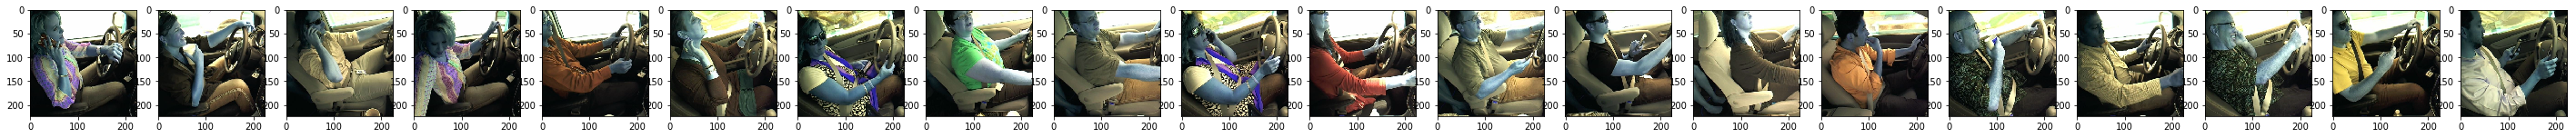

In [18]:
# labels is the image array
test_image = []
i = 0
fig, ax = plt.subplots(1, 20, figsize = (50,50 ))

files = os.listdir('/home/jupyter/TestImages')
nums = np.random.randint(low=1, high=len(files), size=20)
for i in range(20):
    print ('Image number:',i)
    img = cv2.imread('/home/jupyter/TestImages/'+files[nums[i]])
    #img = color.rgb2gray(img)
    img = img[50:,120:-50]
    img = cv2.resize(img,(224,224))
    test_image.append(img)
    ax[i].imshow(img,cmap = 'gray')
    plt.show


In [20]:
test = []

for img in test_image:
    test.append(img)
    
model.load_weights('mobilenet_sgd_nolayers.hdf5')


test = np.array(test).reshape(-1,224,224,3)
prediction = model.predict(test)

In [21]:
prediction[0]

array([3.1212267e-02, 2.2862609e-04, 4.3568566e-01, 4.2735897e-05,
       2.2238886e-03, 1.8685360e-02, 2.3453742e-01, 3.4454674e-04,
       1.7441784e-01, 1.0262165e-01], dtype=float32)

In [22]:
tags = { "C0": "safe driving",
"C1": "texting - right",
"C2": "talking on the phone - right",
"C3": "texting - left",
"C4": "talking on the phone - left",
"C5": "operating the radio",
"C6": "drinking",
"C7": "reaching behind",
"C8": "hair and makeup",
"C9": "talking to passenger" }

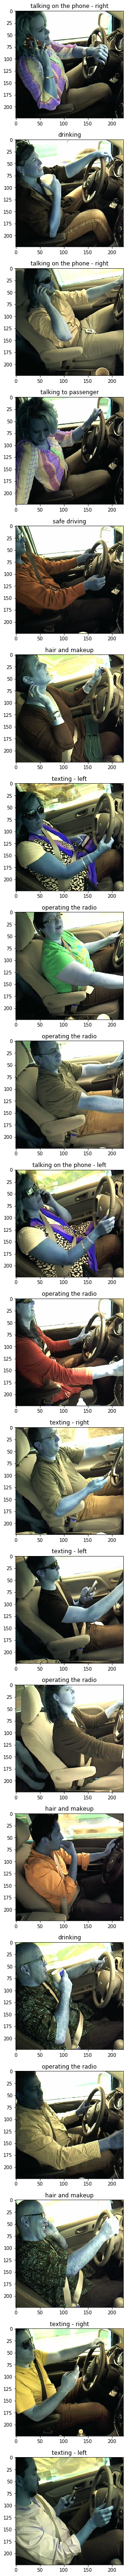

In [23]:
# labels is the image array
i = 0
fig, ax = plt.subplots(20, 1, figsize = (100,100))

for i in range(20):
    ax[i].imshow(test[i].squeeze())
    predicted_class = 'C'+str(np.where(prediction[i] == np.amax(prediction[i]))[0][0])
    ax[i].set_title(tags[predicted_class])
    plt.show
    
